# Planificadores – Tabla por aparición

In [7]:

import pandas as pd, matplotlib.pyplot as plt
from dataclasses import dataclass
plt.rcParams.update({'figure.facecolor':'#111319','axes.facecolor':'#111319',
                     'savefig.facecolor':'#111319','text.color':'white',
                     'axes.labelcolor':'white','xtick.color':'white',
                     'ytick.color':'white','axes.edgecolor':'white'})

proc_df = pd.DataFrame({'Proceso':['P1','P2','P3','P4','P5'],
                        'Tiempo de Llegada':[0,1,2,3,4],
                        'Tiempo de Ejecución':[4,3,5,2,4],
                        'Prioridad':[2,1,3,4,2]})
H=25
proc_df


,Proceso,Tiempo de Llegada,Tiempo de Ejecución,Prioridad
0,P1,0,4,2
1,P2,1,3,1
2,P3,2,5,3
3,P4,3,2,4
4,P5,4,4,2


In [8]:

@dataclass
class Metrics:
    utilizacion_cpu: float
    tasa_procesamiento: float
    tiempo_espera_prom: float


In [9]:

def tabla_por_ap(seg, procs):
    filas=[]
    seg=seg.sort_values('Inicio')
    for _, s in seg.iterrows():
        info=procs[procs.Proceso==s.Proceso].iloc[0]
        llegada=info['Tiempo de Llegada']; ejec=info['Tiempo de Ejecución']
        prev=seg[(seg.Proceso==s.Proceso)&(seg.Fin<=s.Inicio)]
        if prev.empty:
            espera=s.Inicio-llegada; resp=espera
        else:
            espera=s.Inicio-prev.iloc[-1].Fin; resp=None
        filas.append({'Proceso':s.Proceso,'Tiempo de Llegada':llegada,
                      'Tiempo de Ejecución':ejec,'Tiempo de Inicio':s.Inicio,
                      'Tiempo de Espera':espera,'Tiempo de Respuesta':resp,
                      'Tiempo de Fin':s.Fin})
    return pd.DataFrame(filas)

def plot_gantt(seg, procs, H, title):
    cmap=plt.colormaps['tab10']; prots=procs.Proceso.tolist()
    colors={p:cmap(i%10) for i,p in enumerate(prots)}
    fig,ax=plt.subplots(figsize=(10,2.6))
    # barras CPU
    for _,r in seg.iterrows():
        ax.plot([r.Inicio,r.Fin],[0,0],lw=10,color=colors[r.Proceso],label=r.Proceso)
    # puntos de llegada
    for p in prots:
        arr=procs.loc[procs.Proceso==p,'Tiempo de Llegada'].iloc[0]
        ax.scatter(arr,-0.05,marker='v',color=colors[p],s=60,zorder=5)
    ax.set_xlim(0,H); ax.set_ylim(-0.15,0.3); ax.set_xlabel('Tiempo'); ax.set_yticks([])
    ax.set_title(title)
    # leyenda única
    handles,labels=ax.get_legend_handles_labels(); by_label=dict(zip(labels,handles))
    ax.legend(by_label.values(),by_label.keys(),bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()


In [10]:

def fcfs(df,H):
    t=0; seg=[]; ej=esp=0
    for _,r in df.sort_values('Tiempo de Llegada').iterrows():
        if r['Tiempo de Llegada']>t:t=r['Tiempo de Llegada']
        ini,fin=t,t+r['Tiempo de Ejecución']; seg.append({'Proceso':r.Proceso,'Inicio':ini,'Fin':fin})
        t=fin; ej+=r['Tiempo de Ejecución']; esp+=ini-r['Tiempo de Llegada']
    return pd.DataFrame(seg), Metrics(ej/H,len(df)/H,esp/len(df))

def sjf_np(df,H):
    pend=df.sort_values('Tiempo de Llegada').to_dict('records'); t=0; seg=[]; ej=esp=0
    while pend:
        ready=[p for p in pend if p['Tiempo de Llegada']<=t]
        if not ready: t=min(p['Tiempo de Llegada'] for p in pend); continue
        p=min(ready,key=lambda x:x['Tiempo de Ejecución']); pend.remove(p)
        ini,fin=t,t+p['Tiempo de Ejecución']; seg.append({'Proceso':p['Proceso'],'Inicio':ini,'Fin':fin})
        t=fin; ej+=p['Tiempo de Ejecución']; esp+=ini-p['Tiempo de Llegada']
    return pd.DataFrame(seg), Metrics(ej/H,len(df)/H,esp/len(df))

def sjf_p(df,H):
    df=df.sort_values('Tiempo de Llegada'); n=len(df); rem=df['Tiempo de Ejecución'].tolist()
    t=0; seg=[]; act=None; ej=esp=0; comp=0
    while comp<n:
        ready=[i for i in range(n) if df.iloc[i]['Tiempo de Llegada']<=t and rem[i]>0]
        if not ready: t+=1; continue
        idx=min(ready,key=lambda i: rem[i])
        if idx!=act:
            if act is not None: seg[-1]['Fin']=t
            seg.append({'Proceso':df.iloc[idx].Proceso,'Inicio':t,'Fin':None}); act=idx
        rem[idx]-=1; t+=1
        if rem[idx]==0:
            seg[-1]['Fin']=t; comp+=1
            ej+=df.iloc[idx]['Tiempo de Ejecución']
            esp+=t-df.iloc[idx]['Tiempo de Llegada']-df.iloc[idx]['Tiempo de Ejecución']; act=None
    return pd.DataFrame(seg), Metrics(ej/H,n/H,esp/n)

def rr(df,H,q=2):
    queue=[]; procs=df.sort_values('Tiempo de Llegada').to_dict('records'); rem={p['Proceso']:p['Tiempo de Ejecución'] for p in procs}
    t=0; seg=[]; ej=esp=0; comp=0
    while comp<len(rem):
        while procs and procs[0]['Tiempo de Llegada']<=t: queue.append(procs.pop(0))
        if not queue: t=procs[0]['Tiempo de Llegada']; continue
        p=queue.pop(0); name=p['Proceso']; ini=t; run=min(q,rem[name]); t+=run; rem[name]-=run
        seg.append({'Proceso':name,'Inicio':ini,'Fin':t})
        while procs and procs[0]['Tiempo de Llegada']<=t: queue.append(procs.pop(0))
        if rem[name]>0: queue.append(p)
        else: comp+=1; ej+=p['Tiempo de Ejecución']; esp+=t-p['Tiempo de Llegada']-p['Tiempo de Ejecución']
    return pd.DataFrame(seg), Metrics(ej/H,len(df)/H,esp/len(df))

def prio_np(df,H):
    pend=df.sort_values('Tiempo de Llegada').to_dict('records'); t=0; seg=[]; ej=esp=0
    while pend:
        ready=[p for p in pend if p['Tiempo de Llegada']<=t]
        if not ready: t=min(p['Tiempo de Llegada'] for p in pend); continue
        p=min(ready,key=lambda x:(x['Prioridad'],x['Tiempo de Llegada'])); pend.remove(p)
        ini,fin=t,t+p['Tiempo de Ejecución']; seg.append({'Proceso':p['Proceso'],'Inicio':ini,'Fin':fin})
        t=fin; ej+=p['Tiempo de Ejecución']; esp+=ini-p['Tiempo de Llegada']
    return pd.DataFrame(seg), Metrics(ej/H,len(df)/H,esp/len(df))

def prio_p(df,H):
    df=df.sort_values('Tiempo de Llegada'); n=len(df); rem=df['Tiempo de Ejecución'].tolist(); pr=df['Prioridad'].tolist()
    t=0; seg=[]; act=None; ej=esp=0; comp=0
    while comp<n:
        ready=[i for i in range(n) if df.iloc[i]['Tiempo de Llegada']<=t and rem[i]>0]
        if not ready: t+=1; continue
        idx=min(ready,key=lambda i:(pr[i],0 if i==act else 1))
        if idx!=act:
            if act is not None: seg[-1]['Fin']=t
            seg.append({'Proceso':df.iloc[idx].Proceso,'Inicio':t,'Fin':None}); act=idx
        rem[idx]-=1; t+=1
        if rem[idx]==0:
            seg[-1]['Fin']=t; comp+=1; ej+=df.iloc[idx]['Tiempo de Ejecución']
            esp+=t-df.iloc[idx]['Tiempo de Llegada']-df.iloc[idx]['Tiempo de Ejecución']; act=None
    return pd.DataFrame(seg), Metrics(ej/H,n/H,esp/n)



=== FCFS ===
 Metrics(utilizacion_cpu=0.72, tasa_procesamiento=0.2, tiempo_espera_prom=5.4)


,Proceso,Tiempo de Llegada,Tiempo de Ejecución,Tiempo de Inicio,Tiempo de Espera,Tiempo de Respuesta,Tiempo de Fin
0,P1,0,4,0,0,0,4
1,P2,1,3,4,3,3,7
2,P3,2,5,7,5,5,12
3,P4,3,2,12,9,9,14
4,P5,4,4,14,10,10,18


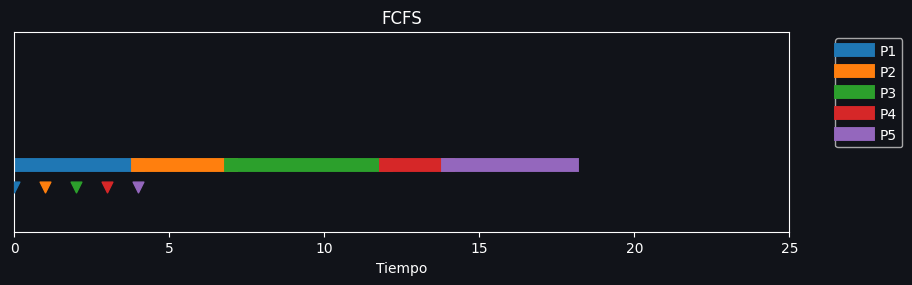


=== SJF ===
 Metrics(utilizacion_cpu=0.72, tasa_procesamiento=0.2, tiempo_espera_prom=4.4)


,Proceso,Tiempo de Llegada,Tiempo de Ejecución,Tiempo de Inicio,Tiempo de Espera,Tiempo de Respuesta,Tiempo de Fin
0,P1,0,4,0,0,0,4
1,P4,3,2,4,1,1,6
2,P2,1,3,6,5,5,9
3,P5,4,4,9,5,5,13
4,P3,2,5,13,11,11,18


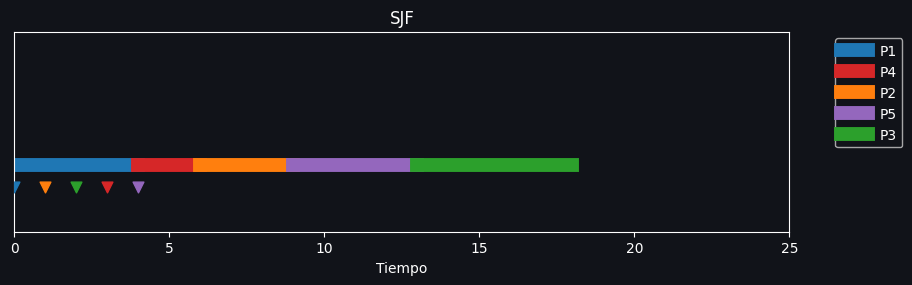


=== SRTF ===
 Metrics(utilizacion_cpu=np.float64(0.72), tasa_procesamiento=0.2, tiempo_espera_prom=np.float64(4.4))


,Proceso,Tiempo de Llegada,Tiempo de Ejecución,Tiempo de Inicio,Tiempo de Espera,Tiempo de Respuesta,Tiempo de Fin
0,P1,0,4,0,0,0,4
1,P4,3,2,4,1,1,6
2,P2,1,3,6,5,5,9
3,P5,4,4,9,5,5,13
4,P3,2,5,13,11,11,18


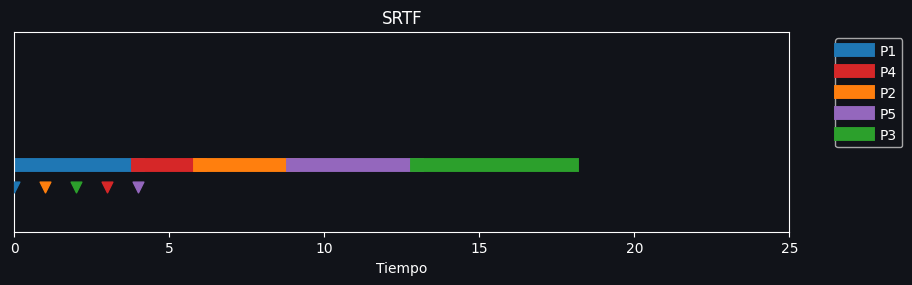


=== RR (q=2) ===
 Metrics(utilizacion_cpu=0.72, tasa_procesamiento=0.2, tiempo_espera_prom=7.6)


,Proceso,Tiempo de Llegada,Tiempo de Ejecución,Tiempo de Inicio,Tiempo de Espera,Tiempo de Respuesta,Tiempo de Fin
0,P1,0,4,0,0,0.0,2
1,P2,1,3,2,1,1.0,4
2,P3,2,5,4,2,2.0,6
3,P1,0,4,6,4,NaN,8
4,P4,3,2,8,5,5.0,10
5,P5,4,4,10,6,6.0,12
6,P2,1,3,12,8,NaN,13
7,P3,2,5,13,7,NaN,15
8,P5,4,4,15,3,NaN,17
9,P3,2,5,17,2,NaN,18


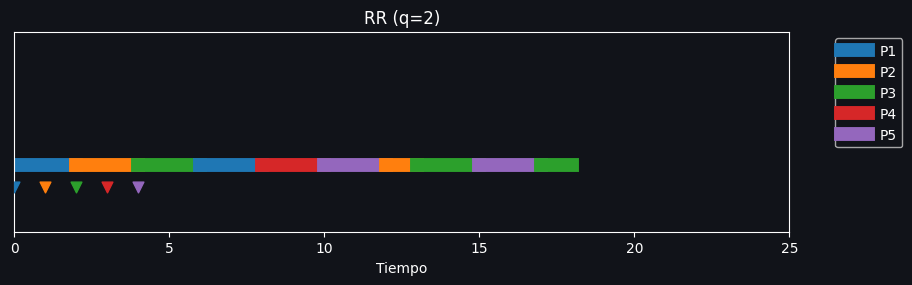


=== Prioridad NP ===
 Metrics(utilizacion_cpu=0.72, tasa_procesamiento=0.2, tiempo_espera_prom=5.6)


,Proceso,Tiempo de Llegada,Tiempo de Ejecución,Tiempo de Inicio,Tiempo de Espera,Tiempo de Respuesta,Tiempo de Fin
0,P1,0,4,0,0,0,4
1,P2,1,3,4,3,3,7
2,P5,4,4,7,3,3,11
3,P3,2,5,11,9,9,16
4,P4,3,2,16,13,13,18


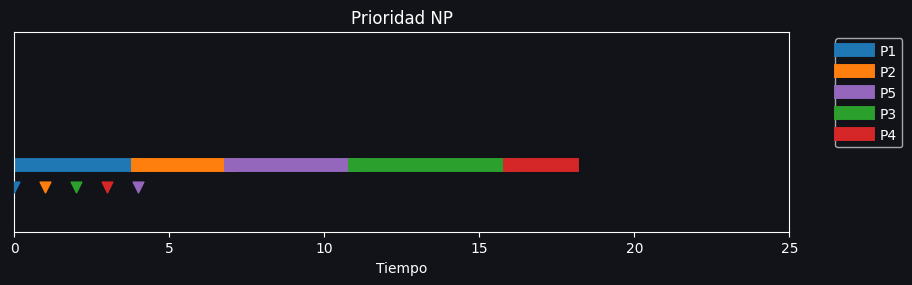


=== Prioridad P ===
 Metrics(utilizacion_cpu=np.float64(0.72), tasa_procesamiento=0.2, tiempo_espera_prom=np.float64(5.6))


,Proceso,Tiempo de Llegada,Tiempo de Ejecución,Tiempo de Inicio,Tiempo de Espera,Tiempo de Respuesta,Tiempo de Fin
0,P1,0,4,0,0,0.0,1
1,P2,1,3,1,0,0.0,4
2,P1,0,4,4,3,NaN,7
3,P5,4,4,7,3,3.0,11
4,P3,2,5,11,9,9.0,16
5,P4,3,2,16,13,13.0,18


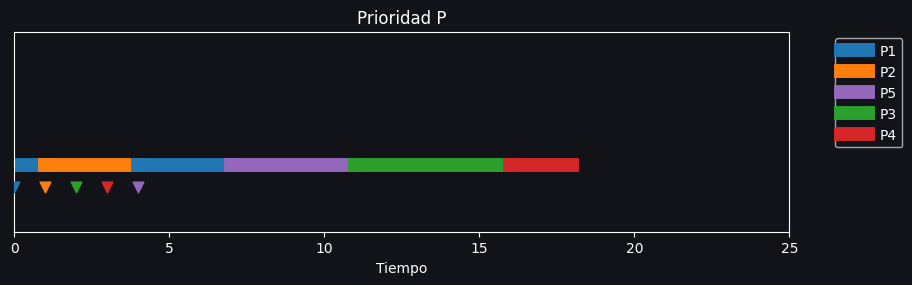

In [11]:

algos={'FCFS':fcfs,'SJF':sjf_np,'SRTF':sjf_p,'RR (q=2)':lambda d=proc_df: rr(proc_df,H,2),
       'Prioridad NP':prio_np,'Prioridad P':prio_p}

for nombre,fn in algos.items():
    seg,met = fn(proc_df, H) if nombre not in ['RR (q=2)'] else fn()
    tabla = tabla_por_ap(seg, proc_df)
    print(f"\n=== {nombre} ===\n",met)
    display(tabla)
    plot_gantt(seg, proc_df, H, nombre)
